# Import necessary libraries

In [5]:
# !pip install opencv-python
# !pip install pandas
# !pip install matplotlib
# !pip install scikit-learn
# !pip install imutils
# !pip install easyocr

In [6]:
import cv2 
import time
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from imutils.object_detection import non_max_suppression

In [7]:
import easyocr

# A function to return Text Detected Image 

### - K-mean clustering for detected rectangles
### - EAST text Detector

In [8]:
def k_mean_clustering(rectangles, clusters):
    
    centroids = np.array([[ (x_min + x_max) / 2, (y_min + y_max) / 2] for (x_min, y_min, x_max, y_max) in rectangles])

    n_clusters = clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(centroids)
    
    largest_rectangles = []
    
    for cluster in range(n_clusters):
        cluster_indices = np.where(clusters == cluster)[0]
        cluster_rectangles = [rectangles[i] for i in cluster_indices]
        
        largest_rectangle = max(cluster_rectangles, key=lambda rect: (rect[2] - rect[0]) * (rect[3] - rect[1]))
        largest_rectangles.append(largest_rectangle)
    
    # Plot the results
    plt.figure(figsize=(9, 6))
    # Plot original rectangles
    for (x_min, y_min, x_max, y_max) in rectangles:
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=None, edgecolor='gray', linewidth=1))
    # Plot largest rectangles from each cluster
    for (x_min, y_min, x_max, y_max) in largest_rectangles:
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=None, edgecolor='red', linewidth=2))
    
    plt.title('Rectangles Clustering and Largest Rectangle in Each Cluster')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.grid()
    plt.axis('equal')
    plt.gca().invert_yaxis()
    plt.show()
    
    return largest_rectangles

In [9]:
def text_detector(image, clusters):

    # It is already a pretrained model for detecting text location, but not to recognnize it
    model_fetd = cv2.dnn.readNet("models/frozen_east_text_detection.pb")
    
    orig = copy.deepcopy(image)
    temp_image = copy.deepcopy(image)
    (H, W) = temp_image.shape[:2]
    
    (newW, newH) = (320, 320)
    rW = W / float(newW)
    rH = H / float(newH)
    
    temp_image = cv2.resize(temp_image, (newW, newH))
    (H, W) = temp_image.shape[:2]
    
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]
    
    
    blob = cv2.dnn.blobFromImage(temp_image, 1.0, (W, H),
        (123.68, 116.78, 103.94), swapRB=True, crop=False)
    
    model_fetd.setInput(blob)
    (scores, geometry) = model_fetd.forward(layerNames)
    
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    
    for y in range(0, numRows):
    
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
    
        for x in range(0, numCols):
        
            if scoresData[x] < 0.1:
                continue
            
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x])) 
            
            if int(endX - w) - int((1/4)*w) >= 0:
                startX = int(endX - w) - int((1/4)*w) ###
            if int(endY - h) - int((1/4)*h) >= 0:
                startY = int(endY - h) - int((1/4)*h) ###

            endX += int((1/4)*w) ###
            endY += int((1/4)*h) ###

            startX = int(startX * rW)
            startY = int(startY * rH)
            endX = int(endX * rW)
            endY = int(endY * rH) 
            
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
            
    #boxes = non_max_suppression(np.array(rects), probs=confidences)
    rects = k_mean_clustering(rects, clusters)
    
    for (startX, startY, endX, endY) in rects:
        # startX = int(startX * rW)
        # startY = int(startY * rH)
        # endX = int(endX * rW)
        # endY = int(endY * rH) 
        boundary = 2
    
        text = orig[startY-boundary:endY+boundary, startX - boundary:endX + boundary]
        text = cv2.cvtColor(text.astype(np.uint8), cv2.COLOR_BGR2GRAY)
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 3)
        orig = cv2.putText(orig, "", (endX,endY+5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA) 
    
    return orig, rects

# Usage of function

### Step 1: Load and Display the Original Image

In [10]:
image = cv2.imread('images/license.png')
image.shape

(834, 1333, 3)

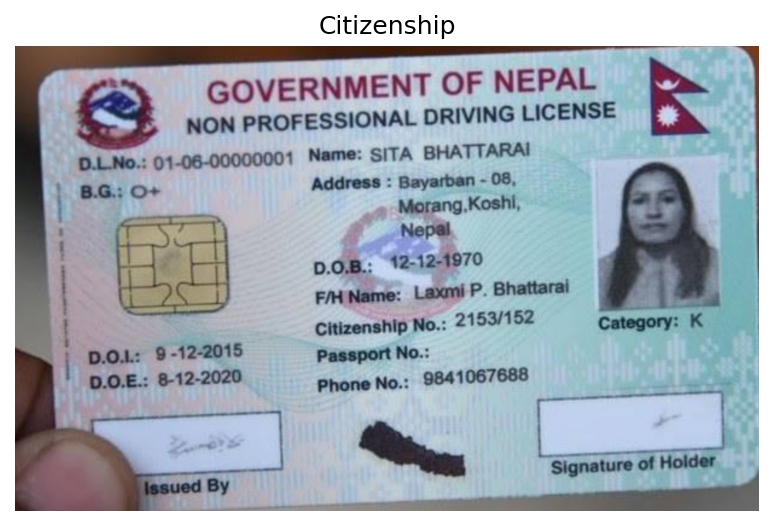

In [11]:
# Convert from BGR (OpenCV default) to RGB (for better display in matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Set higher DPI for better quality display
plt.figure(dpi=150)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')
plt.title('Citizenship')
plt.show()

### Step 2: Detecting text without any preprocessing image

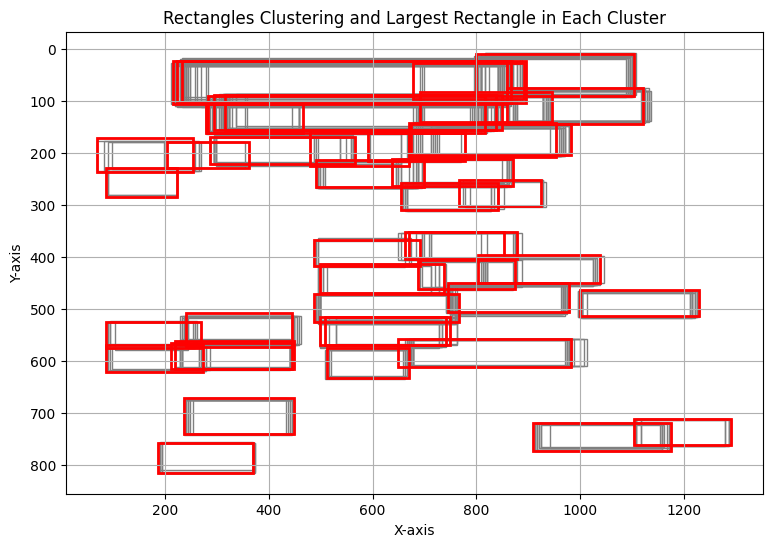

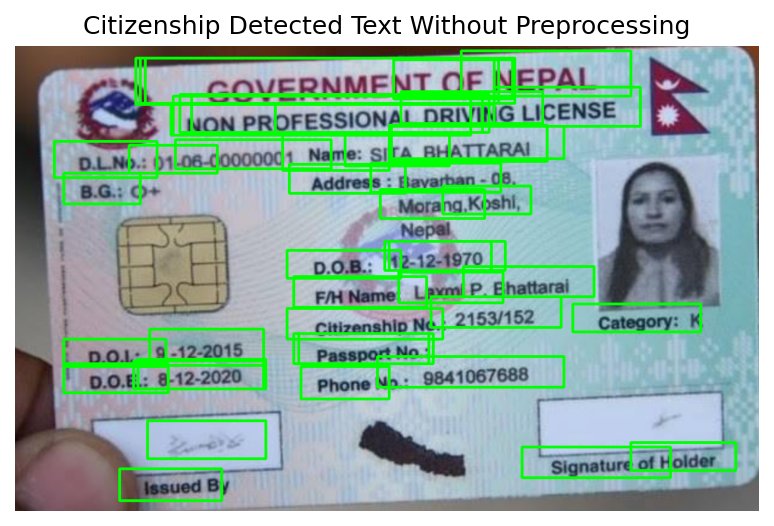

In [12]:
image_TextDetected = text_detector(image, 45)[0]

image_TextDetected_rgb = cv2.cvtColor(image_TextDetected, cv2.COLOR_BGR2RGB)

plt.figure(dpi=150)
plt.imshow(image_TextDetected_rgb)
plt.title("Citizenship Detected Text Without Preprocessing")
plt.axis('off')
plt.show()

### Step 3: Preprocessing image

#### - A function for enhancing image which consists of standard stepwise preprocessing of an image.

In [13]:
def enhance_image_stepwise(image_array, contrast=1.5, brightness=2):

    # Step 1: Denoise the image (optional, can be adjusted or skipped)
    denoised_image = cv2.bilateralFilter(image_array, d=9, sigmaColor=75, sigmaSpace=75)
    
    # Step 2: Increase contrast using histogram equalization
    contrast_enhanced = cv2.convertScaleAbs(image_array, alpha=contrast, beta=brightness)
    
    # Step 3: Strong sharpening with a custom kernel
    strong_sharpen_kernel = np.array([[0, -1, 0],
                                      [-1, 5, -1],
                                      [0, -1, 0]])  # More aggressive sharpening
    sharpened = cv2.filter2D(contrast_enhanced, -1, strong_sharpen_kernel)
    
    # Step 4: Apply adaptive thresholding to make text black and background white
    enhanced_text = cv2.adaptiveThreshold(sharpened, 255, 
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY, 
                                          11, 2)
    
    return enhanced_text

#### - Converting the original image to grayscale and visualizing

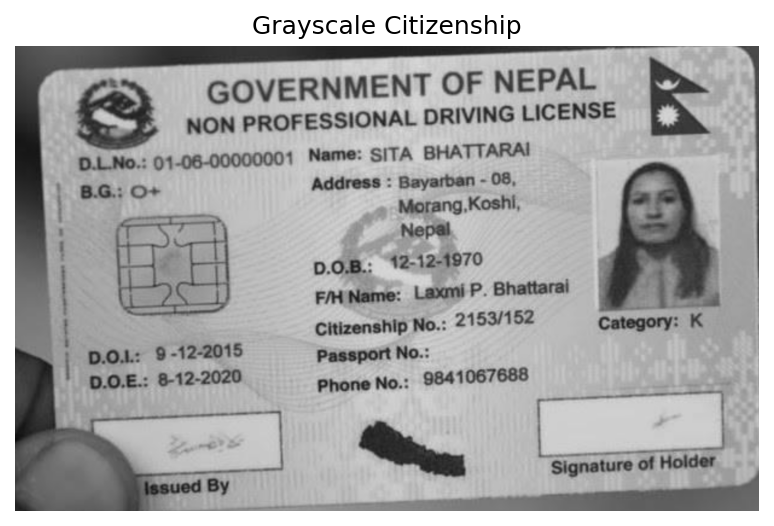

In [14]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gray_image_rgb = cv2.cvtColor(gray_image, cv2.COLOR_BGR2RGB)

plt.figure(dpi=150)
plt.imshow(gray_image_rgb)
plt.title("Grayscale Citizenship")
plt.axis('off')
plt.show()

#### - Enhancing the image using above function and visualizing

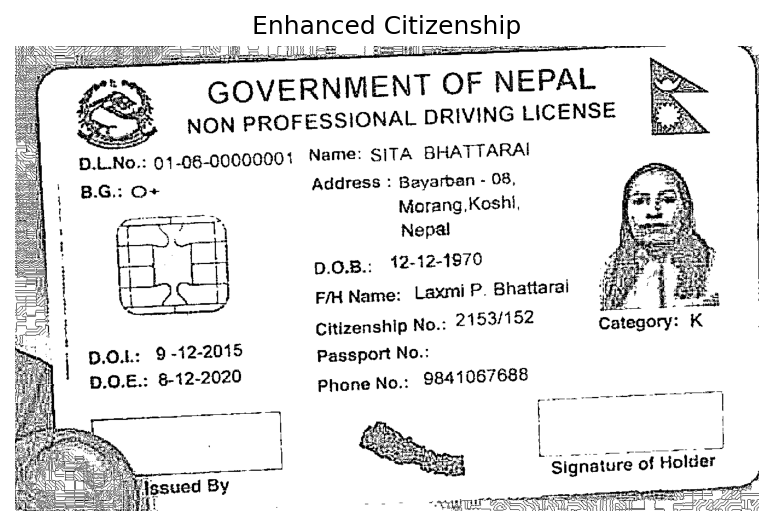

In [15]:
enhanced_image = enhance_image_stepwise(gray_image, contrast=2)

enhanced_image_rgb = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB)

plt.figure(dpi=150)
plt.imshow(enhanced_image_rgb)
plt.title("Enhanced Citizenship")
plt.axis('off')
plt.show()

### Step 4: Detecting text after enhancing

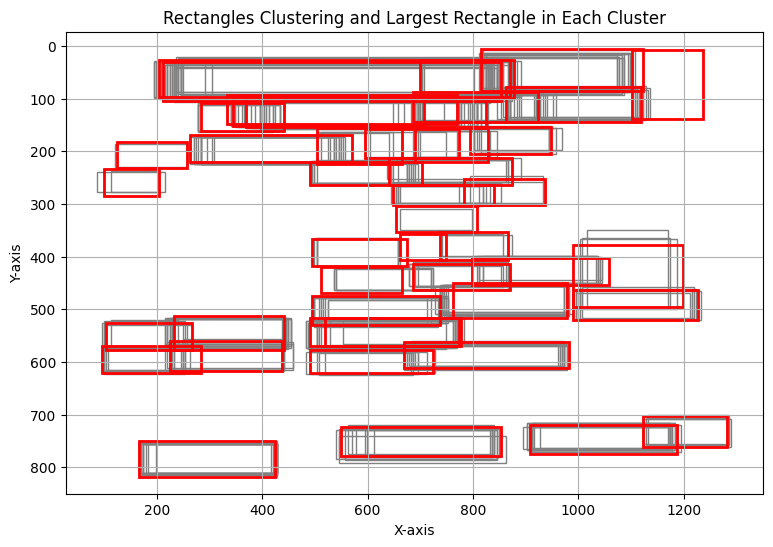

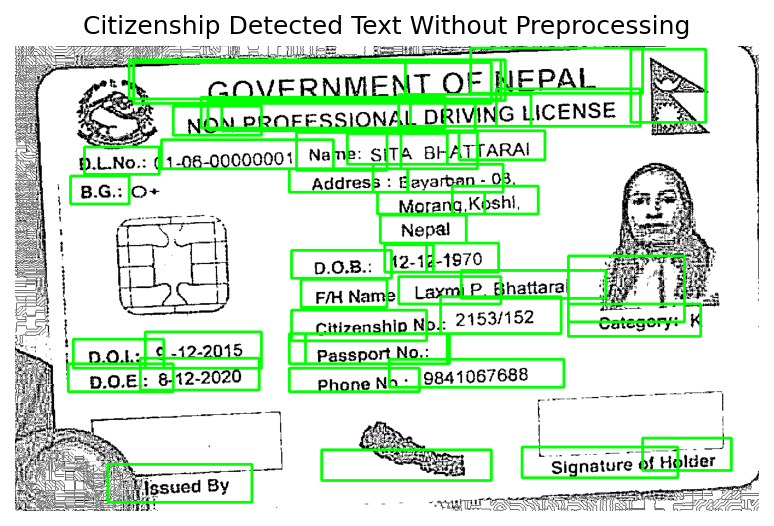

In [16]:
enhanced_image_TextDetected, rects_detected = text_detector(enhanced_image_rgb, 45)

enhanced_image_TextDetected_rgb = cv2.cvtColor(enhanced_image_TextDetected, cv2.COLOR_BGR2RGB)

plt.figure(dpi=150)
plt.imshow(enhanced_image_TextDetected_rgb)
plt.title("Citizenship Detected Text Without Preprocessing")
plt.axis('off')
plt.show()

### Step 4: Extract each detected images

In [17]:
def plot_regions(rectangles, image):
    num_cols = 4
    num_images = len(rectangles)
    num_rows = (num_images + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
    axes = axes.flatten()
    
    for idx, (x1, y1, x2, y2) in enumerate(rectangles):

        roi = image[y1:y2, x1:x2]
        roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(roi_rgb)
        axes[idx].axis('off')  # Hide axes
        axes[idx].set_title(f'Region {idx + 1}')
    
    for j in range(num_images, num_rows * num_cols):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

In [18]:
# plot_regions(rects_detected, enhanced_image_rgb)

# Using MSER model for Text Detection

In [19]:
model_mser = cv2.MSER_create()

In [20]:
def convert_rectangle(rect):
    
    x_start, y_start, x_end, y_end = rect

    new_x_start = int(x_start - (1/10) * (x_end - x_start))
    new_y_start = int(y_start - (1/5) * (y_end - y_start))

    if new_x_start < 0:
        new_x_start = 0
    if new_y_start < 0:
        new_y_start = 0
    
    new_x_end = int(x_end + (1/10) * (x_end - x_start))
    new_y_end = int(y_end + (1/4) * (y_end - y_start))
    
    return [new_x_start, new_y_start, new_x_end, new_y_end]

In [21]:
def calculate_metrics(rects):
    metrics = []
    for rect in rects:
        x_start, y_start, x_end, y_end = rect
        width = x_end - x_start
        height = y_end - y_start
        area = width * height
        aspect_ratio = width / height if height != 0 else 0  # Prevent division by zero
        metrics.append([width, height, aspect_ratio, area])
    return metrics



def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 7 * IQR
    upper_bound = Q3 + 7 * IQR
    return (data < lower_bound) | (data > upper_bound)



def remove_outliers(rects):
    metrics = calculate_metrics(rects)
    df = pd.DataFrame(metrics, columns=['Width', 'Height', 'Aspect Ratio', 'Area'])
    outliers = {
        'Width': detect_outliers_iqr(df['Width']),
        'Height': detect_outliers_iqr(df['Height']),
        'Aspect Ratio': detect_outliers_iqr(df['Aspect Ratio']),
        'Area': detect_outliers_iqr(df['Area'])
    }
    df['Is Outlier'] = outliers['Width'] | outliers['Height'] | outliers['Aspect Ratio'] | outliers['Area']
    clean_rectangles = df[~df['Is Outlier']]

    return [rects[i] for i in clean_rectangles.index]

In [22]:
def is_adjacent(rect1, rect2, threshold_x, threshold_y):
    """Check if two rectangles are adjacent based on given thresholds."""
    x1_start, y1_start, x1_end, y1_end = rect1
    x2_start, y2_start, x2_end, y2_end = rect2

    # Check if they are close enough in the x direction and overlapping in the y direction
    close_x = (x1_end + threshold_x >= x2_start) and (x2_end + threshold_x >= x1_start)
    close_y = (y1_end + threshold_y >= y2_start) and (y2_end + threshold_y >= y1_start)

    return close_x and close_y



def merge_adjacent_rectangles(rects, threshold_x, threshold_y):
    """Merge rectangles based on adjacency thresholds."""
    merged = []
    visited = set()

    for i in range(len(rects)):
        if i in visited:
            continue
        current_group = [rects[i]]
        visited.add(i)

        for j in range(len(rects)):
            if j != i and j not in visited:
                if is_adjacent(rects[i], rects[j], threshold_x, threshold_y):
                    current_group.append(rects[j])
                    visited.add(j)

        x_start = min(rect[0] for rect in current_group)
        y_start = min(rect[1] for rect in current_group)
        x_end = max(rect[2] for rect in current_group)
        y_end = max(rect[3] for rect in current_group)

        merged.append([x_start, y_start, x_end, y_end])

    return merged

In [23]:
def mser_text_detection(image):
    regions, _ = model_mser.detectRegions(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    rectangles = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 20 and h > 20:
            rectangles.append([x, y, x + w, y + h])

    rectangles = remove_outliers(rectangles)
    rectangles = merge_adjacent_rectangles(rectangles, 100, 5)
    rectangles = merge_adjacent_rectangles(rectangles, 10, 5)
    rectangles = [convert_rectangle(rect) for rect in rectangles]

    output_image = image.copy()
    for (x1, y1, x2, y2) in rectangles:
        cv2.rectangle(output_image, (x1, y1), (x2, y2), (0, 255, 0), 3)

    plt.figure(dpi=150)
    plt.imshow(output_image, cmap='gray')
    plt.axis('off')
    plt.title('MSER Text Detection')
    plt.show()

    return rectangles

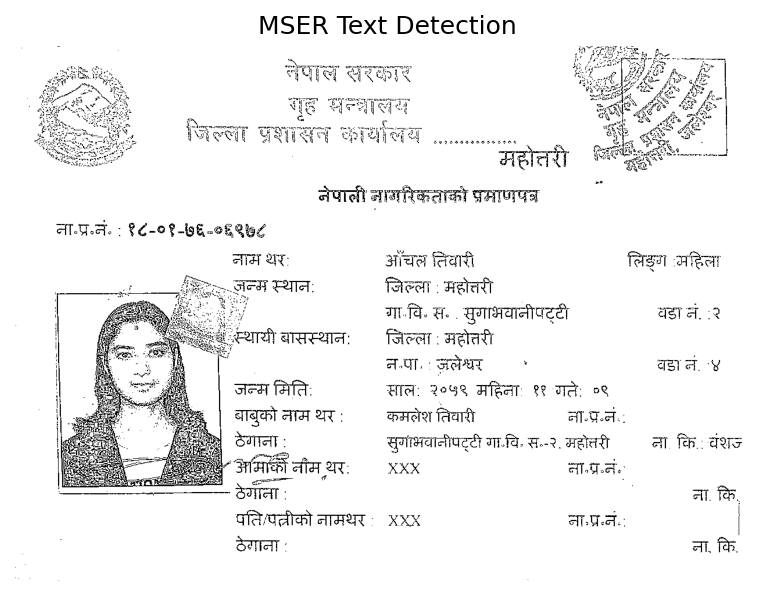

In [26]:
check_image = cv2.imread('images/aachal.jpg')
check_gray_image = cv2.cvtColor(check_image, cv2.COLOR_BGR2GRAY)
check_enhanced_image = enhance_image_stepwise(check_gray_image, contrast=2)

check_enhanced_image_rgb = cv2.cvtColor(check_enhanced_image, cv2.COLOR_BGR2RGB)

plt.figure(dpi=150)
plt.imshow(check_enhanced_image_rgb)
plt.axis('off')
plt.title('MSER Text Detection')
plt.show()

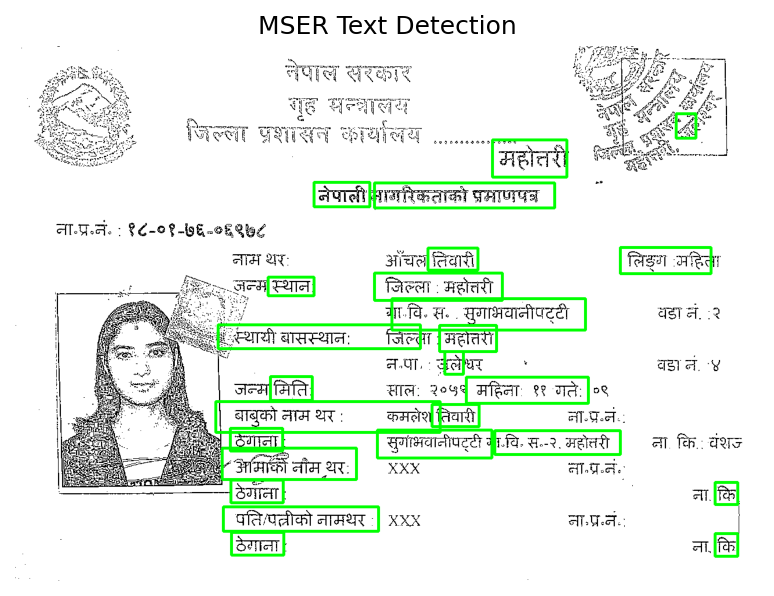

In [27]:
rectangles = mser_text_detection(check_enhanced_image_rgb)
# rectangles

In [28]:
# plot_regions(rectangles, check_enhanced_image_rgb)

# EasyOCR Text Detection

### - EasyOCR function

In [29]:
reader = easyocr.Reader(['en'], gpu=True)

In [30]:
def easyocr_text_detection(orig):

    image = copy.deepcopy(orig)
    
    result = reader.readtext(image)

    rectangles = []
    
    # Draw bounding boxes
    for (bbox, text, prob) in result:
        (top_left, top_right, bottom_right, bottom_left) = bbox
        top_left = tuple(map(int, top_left))
        bottom_right = tuple(map(int, bottom_right))
        
        x1, y1 = top_left
        x2, y2 = bottom_right
        x1, x2 = min(x1, x2), max(x1, x2)
        y1, y2 = min(y1, y2), max(y1, y2)
        
        rectangles.append([x1, y1, x2, y2])
        # print([x1, y1, x2, y2])
        
        cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(dpi=150)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Citizenship')
    plt.show()
    
    return rectangles

### - Use without preprocessing

In [31]:
image = cv2.imread('images/citizenship.jpg')
# _ = easyocr_text_detection(image)

### -Use after preprocessing

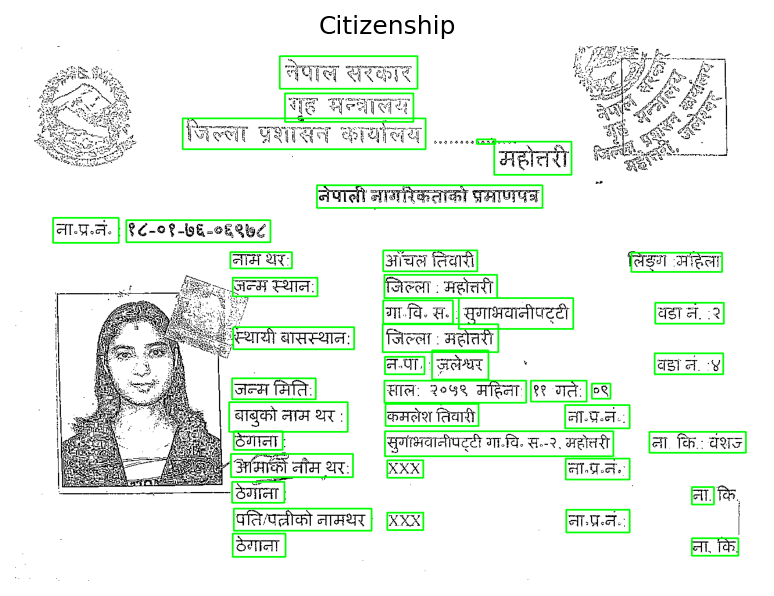

In [34]:
# path for any document either in English or Nepali is okay
image = cv2.imread('images/aachal.jpg')
# image = cv2.resize(image, (1000, 700))
# height, width = image.shape[:2]
# print(height, width)

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
enhanced_image = enhance_image_stepwise(gray_image, contrast=1.9)
enhanced_image_rgb = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB)

rectangles = easyocr_text_detection(enhanced_image_rgb)

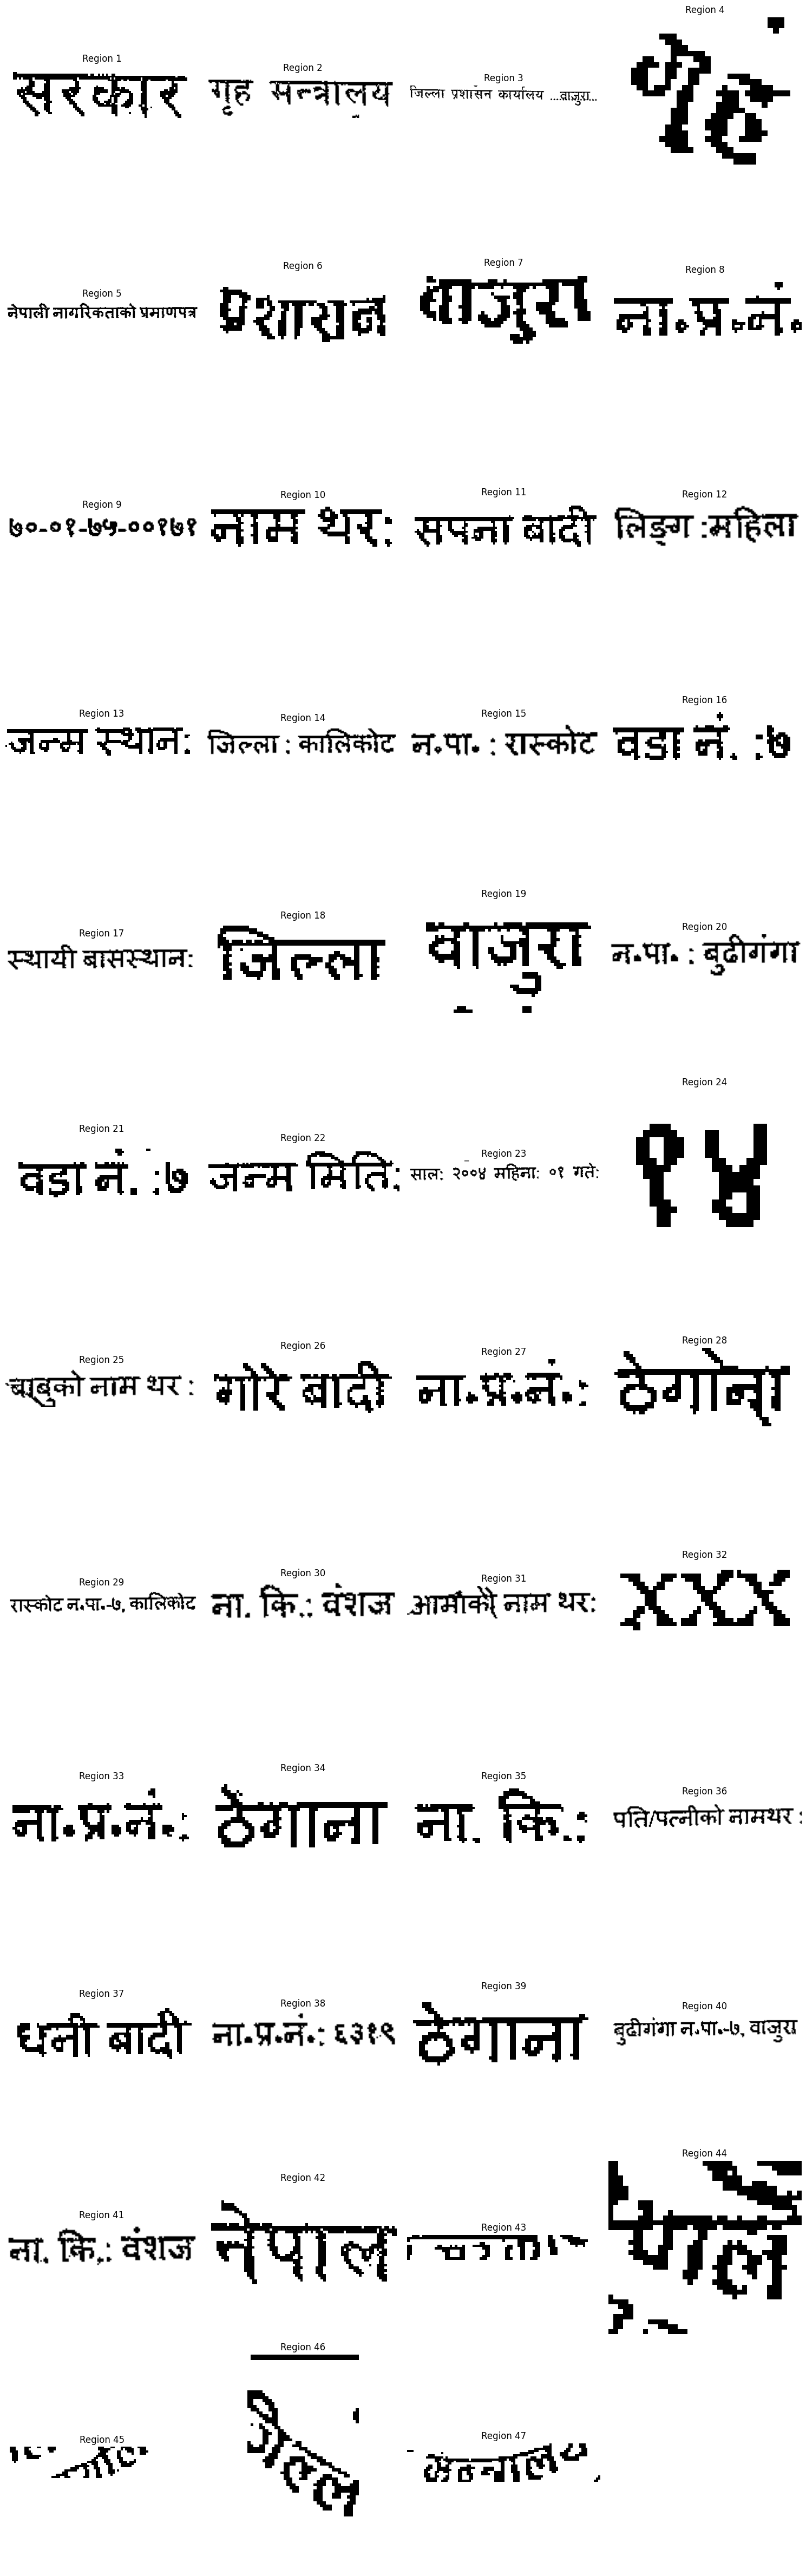

In [33]:
plot_regions(rectangles, enhanced_image_rgb)